In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

from train_utils import *
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from copy import deepcopy

import uproot
from root_pandas import read_root


import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

Welcome to JupyROOT 6.22/02
You are running on  wudangshan


In [2]:
# Load the data

def load_data(debug=False):
    idir = '{}'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')
    file_tth = "{}/tree_2lss1tau.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)
    if debug:
        data_tth_orig.describe()
    return data_tth_orig

In [3]:
# De-jag the data with respect to the jets

def dejag_data(data, debug=False):
    test=data['SelJet_pt']
    l = [len(i) for i in test]
    maxl = max(l)

    for lab in ['pt', 'eta', 'phi', 'mass', 'isBtag', 'isFromHadTop', 'btagDeepFlavB']:
        label='SelJet_%s'%lab
        tempLab=data[label]
        data.drop([label], axis=1, inplace=True)
        out = pd.DataFrame(tempLab.tolist(),columns=[ 'SelJet%s_%s'%(i, lab) for i in range(maxl)])
        data = pd.concat([data, out], axis=1)
    return data


In [4]:
# Remove ill-defined mass columns
def remove_masses(data, debug=False):
    for lab in data.columns:
        if 'mass' in lab:
            data.drop([lab], axis=1, inplace=True)
    return data

In [5]:
def load_feature_names(useJets=0, debug=False):
    thevars=[
            'Lep1_pt', 
            'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
             'nSelJets',
             'met', 'met_phi', 
             'HTT_score', 
             'Hj_tagger_hadTop',
             'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
             'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
             'dEtaBB_LLframe_2lss',
             'dEtaBB_2lss',
             'mTTH_2lss1tau',
             'theta_higgs_ttbar_TTHsystem_2lss1tau',
             'thetaTopTop_ttbarframe_2lss1tau', 
             'Tau_pt', 'Tau_eta', 'Tau_phi'
            ]
    if useJets>0:
        for i in range(useJets):
            thevars.append('SelJet%s_pt'%i)
            thevars.append('SelJet%s_eta'%i)
            thevars.append('SelJet%s_phi'%i)
            #thevars.append('SelJet%s_mass'%i)
            thevars.append('SelJet%s_isBtag'%i)
            thevars.append('SelJet%s_isFromHadTop'%i)
            thevars.append('SelJet%s_btagDeepFlavB'%i)
    if debug:
        print('Training features:', thevars)
        
    return thevars


In [6]:
def get_train_and_test(data, features, oddevensplit=False, fillna=False, debug=False):
    labs=deepcopy(features)
    if oddevensplit:
        labs.append('event')
    bkg = data[labs]
    sig = data[labs]

    if fillna:
        bkg.fillna(0, inplace=True)
        sig.fillna(0, inplace=True)


    wgtbkg=pd.DataFrame(data['weight_SM'].tolist(), columns=['weight'])
    wgtsig=pd.DataFrame(data['weight_CP_odd'].tolist(), columns=['weight'])

    labbkg = pd.DataFrame(np.zeros_like(bkg[features[0]]).tolist(), columns=['label'])
    labsig = pd.DataFrame(np.ones_like(bkg[features[0]]).tolist(), columns=['label'])

    bkg = pd.concat([bkg, wgtbkg, labbkg], axis=1)
    sig = pd.concat([sig, wgtsig, labsig], axis=1)

    sig['weight'] = sig['weight'].apply(lambda x: x if x <10. else 10.)

    labelled_set=pd.concat([sig, bkg], axis=0)
    if False:
        sns.pairplot(labelled_set, hue='label')
    if oddevensplit:
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_wgt=X['weight']

        X_train=X[X['event']%2 == 0]
        X_test =X[X['event']%2 != 0]
        y_train=y[X['event']%2 == 0]
        y_test =y[X['event']%2 != 0]
        
        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_train=X_train.drop(['event'], axis=1, inplace=False)

        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)
        X_test=X_test.drop(['event'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test 
               }
    else:
        labelled_set=shuffle(labelled_set)
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1534534, shuffle=True)

        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test
               }
        #train_dmatrix = xgb.DMatrix(data=X_train,label=y_train,weight=X_train_wgt)
        #test_dmatrix = xgb.DMatrix(data=X_test,label=y_test,weight=X_test_wgt)

    #perm = np.random.permutation(len(X_train))
    #X_train = X_train[perm]
    #y_train = y_train[perm]
    #X_train_wgt = X_train_wgt[perm]

    #perm = np.random.permutation(len(X_train))
    #X_test = X_test[perm]
    #y_test = y_test[perm]
    #X_test_wgt = X_test_wgt[perm]


In [7]:
def plot_features(X, y, wgt, features, label):
    fix, axs= plt.subplots(10,10, figsize=(40,40))
    axs = axs.ravel()

    for i,ax in enumerate(axs):
        if i >= len(features):
            continue
        var=features[i]
        if var=='weight':
            continue
        ax=axs[i]
        #ax.hist(X_train[var], label='%s'%var)
        ax.hist(X[var][y[:]==0 ], weights=wgt[y[:]==0 ], density=True, alpha=0.5, bins=20)
        ax.hist(X[var][y[:]==1 ], weights=wgt[y[:]==1 ], density=True, alpha=0.5, bins=20)
        #ax.set_yscale('log')
        ax.set_title('%s dataset'%label)
        ax.set_xlabel(var)
    plt.show()
    plt.hist(wgt[y[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.yscale("log")
    plt.hist(wgt[y[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.title('%s dataset')
    plt.show()

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)


In [8]:
# Load the data
debug=False
data_tth_orig = load_data(debug=debug)
data_tth=data_tth_orig # save the original
data_tth=dejag_data(data_tth, debug=debug)
data_tth=remove_masses(data_tth, debug=debug)
    
the_initial_vars=load_feature_names(useJets=0, debug=debug) # add "useJets" quadrimomenta of jets


In [9]:
# Train a single model (the basic template)

def train_single_model(params, data, features, oddevensplit=True, fillna=False, debug=False):
    # Start with a first thing with all variables
    datasets= get_train_and_test(data, features, oddevensplit=oddevensplit, fillna=fillna, debug=debug)
    X_train     = datasets['X_train']
    X_test      = datasets['X_test']
    X_train_wgt = datasets['X_train_wgt']
    X_test_wgt  = datasets['X_test_wgt']
    y_train     = datasets['y_train']
    y_test      = datasets['y_test']

    if debug:
        plot_features(X_train, y_train, X_train_wgt, the_initial_vars, 'training')
        plot_features(X_test , y_test , X_test_wgt , the_initial_vars, 'test')
    # WORKING PROTOTYPE: xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=1)
    # Theoretically it should just accept "params=params"
    xg_class = xgb.XGBClassifier(n_estimators=params['n_estimators'], 
                                 max_depth=params['max_depth'],
                                 learning_rate=params['learning_rate'],
                                 subsample=params['subsample'],
                                 colsample_bytree=params['colsample_bytree'],
                                 gamma=params['gamma'])
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xg_class.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])

    preds_train = xg_class.predict_proba(X_train)[:,0]
    preds_test = xg_class.predict_proba(X_test)[:,0]

    #preds_train=np.argmax(xg_class.predict_proba(X_train), axis=1)
    #preds_test =np.argmax(xg_class.predict_proba(X_test), axis=1)

    preds_cat_train = xg_class.predict(X_train)
    preds_cat_test  = xg_class.predict(X_test)
    # ROC curves
    auc_train=plot_roc(y_train, preds_train, sample_weight=X_train_wgt, label='training', plot=False, debug=False)
    auc_test=plot_roc(y_test, preds_test, sample_weight=X_test_wgt, label='test', plot=False, debug=False)

    accuracy_train = accuracy_score(y_train, preds_cat_train,sample_weight=X_train_wgt)
    print("Accuracy (train): %.2f%%" % (accuracy_train * 100.0))
    accuracy_test = accuracy_score(y_test, preds_cat_test, sample_weight=X_test_wgt)
    print("Accuracy (test): %.2f%%" % (accuracy_test * 100.0))

    if debug:
        xgb.plot_importance(xg_class)
        plt.figure(figsize = (16, 12))
        plt.show()        
        results = xg_class.evals_result()
        epochs = len(results['validation_0']['logloss'])
        x_axis = range(0, epochs)
        # plot log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
        ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
        ax.legend()
        plt.ylabel('Log Loss')
        plt.title('XGBoost Log Loss')
        plt.show()
        # plot classification error
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['error'], label='Train')
        ax.plot(x_axis, results['validation_1']['error'], label='Test')
        ax.legend()
        plt.ylabel('Classification Error')
        plt.title('XGBoost Classification Error')
        plt.show()

        cm = confusion_matrix(y_test, preds_cat_test, sample_weight=X_test_wgt)
        plot_confusion_matrix(cm, ['CP odd', 'CP even'])
        plot_rel_pred(y_test, preds_test, 'test')
        plot_pred(y_test, preds_test, 'test')
        plot_weights(X_test_wgt, y_test, 'test')
        
    return {'auc_train': auc_train, 'auc_test': auc_test, 'model': xg_class, 'features': features, 'sorted_importance': dict(sorted(xg_class.get_booster().get_score(importance_type='weight').items(), key=lambda item: item[1])) }

In [10]:
# UNUSED (it claims XGBClassifier doesn't implement the fit() method, which is manifestly untrue)
def run_optimization_randomizedsearch(data, features, oddevensplit=True, fillna=False, debug=False):
    # Here must pass the parameters dictionary params, etc
    # (must change train_single_model to accept the dictionary of parameters,
    # and then set up the full grid scan)
    #train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)

    datasets= get_train_and_test(data, features, oddevensplit=oddevensplit, fillna=fillna, debug=debug)
    X_train     = datasets['X_train']
    X_test      = datasets['X_test']
    X_train_wgt = datasets['X_train_wgt']
    X_test_wgt  = datasets['X_test_wgt']
    y_train     = datasets['y_train']
    y_test      = datasets['y_test']

    grid={'learning_rate' : [0.01, 0.02, 0.05, 0.1],
          'n_estimators' : [50, 100, 200, 500, 1000],
          'max_depth' : [3, 4, 5, 8],
          'subsample' : [0.5, 0.8, 0.9, 1.0],
          'colsample_bytree' : [0.3, 0.5, 0.8, 1.0],
          'gamma' : [0, 1, 5]
         }
    list(ParameterGrid(grid))   
    xg_class = xgb.XGBClassifier(n_estimators=params['n_estimators'], 
                                 max_depth=params['max_depth'],
                                 learning_rate=params['learning_rate'],
                                 subsample=params['subsample'],
                                 colsample_bytree=params['colsample_bytree'],
                                 gamma=params['gamma'])
    
    folds = 3
    param_comb = 5

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
    eval_set = [(X_train, y_train), (X_test, y_test)]
    random_search.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])
    print('\n Best estimator:')
    print(random_search.best_estimator_)
    print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_ * 2 - 1)
    print('\n Best hyperparameters:')
    print(random_search.best_params_)
    return random_search.best_estimator_

In [11]:
# Run the full hyperparameters optimization for a single set of variables

# I know I should use e.g. Parzen tree estimators from hyperopt as I did for the charged Higgs with 2016 dataset,
# but I feel lazy and the hyperparameter space I want to check is actually not that large,
# so I am implementing a simple grid search

def run_optimization(data, features, oddevensplit=True, fillna=False, debug=False):
    # Here must pass the parameters dictionary params, etc
    # (must change train_single_model to accept the dictionary of parameters,
    # and then set up the full grid scan)
    #train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)

    grid={'learning_rate' : [0.01, 0.02, 0.05, 0.1],
          'n_estimators' : [50, 100, 200, 500, 1000],
          'max_depth' : [3, 4, 5, 8],
          'subsample' : [0.5, 0.8, 0.9, 1.0],
          'colsample_bytree' : [0.3, 0.5, 0.8, 1.0],
          'gamma' : [0, 1, 5]
         }
       
    listgrid=list(ParameterGrid(grid))   
    gridresults=[]
    for params in listgrid:
        train_res= train_single_model(params, data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)
        gridresults.append([train_res, train_res['auc_test']])
        print('MAXIMUM HAS NOW AUC', max(gridresults,key=lambda item:item[1])[1])
        print('FULL LIST IS', gridresults)
    return(max(gridresults,key=lambda item:item[1])[0])
    

In [12]:
# Run on a single model
if False:
    params={'learning_rate' : 0.1,
          'n_estimators' : 120,
          'max_depth' : 4,
          'subsample' : 0.8,
          'colsample_bytree' : 1,
          'gamma' : 1
         }
    train_res= train_single_model(params, data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)




In [ ]:
# Full  optimization, where "best" is w.r.t. the AUC metric:
# 1. start with a variable set
# 2. find the model with the best hyperparameter values for that set of variables
# 3. remove the variable that is the least important in this model
# 4. return to point 2
# This ends when removing variables doesnt' improve the AUC anymore


# So far for each variables set I run a single model.
# When I'll have implemented run_optimization (for a given features set) I'll substitute a call to it here
# in place of the call to train_single_model
auc_per_var=[]
features_set=deepcopy(the_initial_vars)
for i in range(len(the_initial_vars)):
    train_res=run_optimization(data_tth, features_set, oddevensplit=True, fillna=False, debug=False)
    auc_per_var.append([train_res['auc_test'], deepcopy(features_set), train_res])
    print('Trained on', features_set) 
    print('or ', train_res['features'])
    print('Importance', train_res['sorted_importance'])
    print('removing ', min(train_res['sorted_importance'].items(), key=lambda x: x[1])[0])
    features_set.remove(min(train_res['sorted_importance'].items(), key=lambda x: x[1])[0])
    print('Next time on', features_set)  

   

[0]	validation_0-error:0.17486	validation_0-logloss:0.68879	validation_1-error:0.17738	validation_1-logloss:0.68883
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17506	validation_0-logloss:0.68467	validation_1-error:0.17726	validation_1-logloss:0.68473
[2]	validation_0-error:0.17504	validation_0-logloss:0.68053	validation_1-error:0.17714	validation_1-logloss:0.68063
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67656
[4]	validation_0-error:0.17504	validation_0-logloss:0.67244	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66858	validation_1-error:0.17714	validation_1-logloss:0.66880
[6]	validation_0-error:0.17504	validation_0-logloss:0.66477	validation_1-error:0.17714	validation_1-logloss:0.66502
[7]	validation_0-error:

[3]	validation_0-error:0.17504	validation_0-logloss:0.67633	validation_1-error:0.17714	validation_1-logloss:0.67649
[4]	validation_0-error:0.17504	validation_0-logloss:0.67240	validation_1-error:0.17714	validation_1-logloss:0.67259
[5]	validation_0-error:0.17504	validation_0-logloss:0.66851	validation_1-error:0.17714	validation_1-logloss:0.66874
[6]	validation_0-error:0.17504	validation_0-logloss:0.66470	validation_1-error:0.17714	validation_1-logloss:0.66497
[7]	validation_0-error:0.17504	validation_0-logloss:0.66098	validation_1-error:0.17714	validation_1-logloss:0.66128
[8]	validation_0-error:0.17504	validation_0-logloss:0.65727	validation_1-error:0.17714	validation_1-logloss:0.65760
[9]	validation_0-error:0.17504	validation_0-logloss:0.65358	validation_1-error:0.17714	validation_1-logloss:0.65395
[10]	validation_0-error:0.17504	validation_0-logloss:0.65002	validation_1-error:0.17714	validation_1-logloss:0.65043
[11]	validation_0-error:0.17504	validation_0-logloss:0.64651	validation

[0]	validation_0-error:0.17480	validation_0-logloss:0.68880	validation_1-error:0.17801	validation_1-logloss:0.68884
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68457	validation_1-error:0.17714	validation_1-logloss:0.68464
[2]	validation_0-error:0.17504	validation_0-logloss:0.68049	validation_1-error:0.17714	validation_1-logloss:0.68060
[3]	validation_0-error:0.17494	validation_0-logloss:0.67636	validation_1-error:0.17714	validation_1-logloss:0.67651
[4]	validation_0-error:0.17504	validation_0-logloss:0.67243	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66854	validation_1-error:0.17714	validation_1-logloss:0.66878
[6]	validation_0-error:0.17504	validation_0-logloss:0.66472	validation_1-error:0.17714	validation_1-logloss:0.66500
[7]	validation_0-error:

[0]	validation_0-error:0.17504	validation_0-logloss:0.68881	validation_1-error:0.17714	validation_1-logloss:0.68884
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68458	validation_1-error:0.17714	validation_1-logloss:0.68467
[2]	validation_0-error:0.17504	validation_0-logloss:0.68045	validation_1-error:0.17714	validation_1-logloss:0.68057
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67658
[4]	validation_0-error:0.17504	validation_0-logloss:0.67247	validation_1-error:0.17714	validation_1-logloss:0.67266
[5]	validation_0-error:0.17504	validation_0-logloss:0.66859	validation_1-error:0.17714	validation_1-logloss:0.66882
[6]	validation_0-error:0.17504	validation_0-logloss:0.66471	validation_1-error:0.17714	validation_1-logloss:0.66497
[7]	validation_0-error:

[0]	validation_0-error:0.17486	validation_0-logloss:0.68879	validation_1-error:0.17738	validation_1-logloss:0.68883
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17506	validation_0-logloss:0.68467	validation_1-error:0.17726	validation_1-logloss:0.68473
[2]	validation_0-error:0.17504	validation_0-logloss:0.68053	validation_1-error:0.17714	validation_1-logloss:0.68063
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67656
[4]	validation_0-error:0.17504	validation_0-logloss:0.67244	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66858	validation_1-error:0.17714	validation_1-logloss:0.66880
[6]	validation_0-error:0.17504	validation_0-logloss:0.66477	validation_1-error:0.17714	validation_1-logloss:0.66502
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52244	validation_1-error:0.17714	validation_1-logloss:0.52492
[70]	validation_0-error:0.17504	validation_0-logloss:0.52123	validation_1-error:0.17714	validation_1-logloss:0.52374
[71]	validation_0-error:0.17504	validation_0-logloss:0.52003	validation_1-error:0.17714	validation_1-logloss:0.52257
[72]	validation_0-error:0.17504	validation_0-logloss:0.51881	validation_1-error:0.17714	validation_1-logloss:0.52138
[73]	validation_0-error:0.17504	validation_0-logloss:0.51767	validation_1-error:0.17714	validation_1-logloss:0.52028
[74]	validation_0-error:0.17504	validation_0-logloss:0.51646	validation_1-error:0.17714	validation_1-logloss:0.51911
[75]	validation_0-error:0.17504	validation_0-logloss:0.51532	validation_1-error:0.17714	validation_1-logloss:0.51800
[76]	validation_0-error:0.17504	validation_0-logloss:0.51421	validation_1-error:0.17714	validation_1-logloss:0.51693
[77]	validation_0-error:0.17504	validation_0-logloss:0.51308	val

[0]	validation_0-error:0.17516	validation_0-logloss:0.68876	validation_1-error:0.17818	validation_1-logloss:0.68880
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68458	validation_1-error:0.17714	validation_1-logloss:0.68465
[2]	validation_0-error:0.17504	validation_0-logloss:0.68046	validation_1-error:0.17714	validation_1-logloss:0.68057
[3]	validation_0-error:0.17504	validation_0-logloss:0.67633	validation_1-error:0.17714	validation_1-logloss:0.67649
[4]	validation_0-error:0.17504	validation_0-logloss:0.67240	validation_1-error:0.17714	validation_1-logloss:0.67259
[5]	validation_0-error:0.17504	validation_0-logloss:0.66851	validation_1-error:0.17714	validation_1-logloss:0.66874
[6]	validation_0-error:0.17504	validation_0-logloss:0.66470	validation_1-error:0.17714	validation_1-logloss:0.66497
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52247	validation_1-error:0.17714	validation_1-logloss:0.52495
[70]	validation_0-error:0.17504	validation_0-logloss:0.52126	validation_1-error:0.17714	validation_1-logloss:0.52377
[71]	validation_0-error:0.17504	validation_0-logloss:0.52007	validation_1-error:0.17714	validation_1-logloss:0.52262
[72]	validation_0-error:0.17504	validation_0-logloss:0.51885	validation_1-error:0.17714	validation_1-logloss:0.52143
[73]	validation_0-error:0.17504	validation_0-logloss:0.51772	validation_1-error:0.17714	validation_1-logloss:0.52033
[74]	validation_0-error:0.17504	validation_0-logloss:0.51652	validation_1-error:0.17714	validation_1-logloss:0.51917
[75]	validation_0-error:0.17504	validation_0-logloss:0.51536	validation_1-error:0.17714	validation_1-logloss:0.51805
[76]	validation_0-error:0.17504	validation_0-logloss:0.51426	validation_1-error:0.17714	validation_1-logloss:0.51698
[77]	validation_0-error:0.17504	validation_0-logloss:0.51315	val

[0]	validation_0-error:0.17480	validation_0-logloss:0.68880	validation_1-error:0.17801	validation_1-logloss:0.68884
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68457	validation_1-error:0.17714	validation_1-logloss:0.68464
[2]	validation_0-error:0.17504	validation_0-logloss:0.68049	validation_1-error:0.17714	validation_1-logloss:0.68060
[3]	validation_0-error:0.17494	validation_0-logloss:0.67636	validation_1-error:0.17714	validation_1-logloss:0.67651
[4]	validation_0-error:0.17504	validation_0-logloss:0.67243	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66854	validation_1-error:0.17714	validation_1-logloss:0.66878
[6]	validation_0-error:0.17504	validation_0-logloss:0.66472	validation_1-error:0.17714	validation_1-logloss:0.66500
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52250	validation_1-error:0.17714	validation_1-logloss:0.52499
[70]	validation_0-error:0.17504	validation_0-logloss:0.52129	validation_1-error:0.17714	validation_1-logloss:0.52381
[71]	validation_0-error:0.17504	validation_0-logloss:0.52010	validation_1-error:0.17714	validation_1-logloss:0.52265
[72]	validation_0-error:0.17504	validation_0-logloss:0.51887	validation_1-error:0.17714	validation_1-logloss:0.52146
[73]	validation_0-error:0.17504	validation_0-logloss:0.51773	validation_1-error:0.17714	validation_1-logloss:0.52035
[74]	validation_0-error:0.17504	validation_0-logloss:0.51655	validation_1-error:0.17714	validation_1-logloss:0.51919
[75]	validation_0-error:0.17504	validation_0-logloss:0.51540	validation_1-error:0.17714	validation_1-logloss:0.51807
[76]	validation_0-error:0.17504	validation_0-logloss:0.51430	validation_1-error:0.17714	validation_1-logloss:0.51700
[77]	validation_0-error:0.17504	validation_0-logloss:0.51319	val

[0]	validation_0-error:0.17504	validation_0-logloss:0.68881	validation_1-error:0.17714	validation_1-logloss:0.68884
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68458	validation_1-error:0.17714	validation_1-logloss:0.68467
[2]	validation_0-error:0.17504	validation_0-logloss:0.68045	validation_1-error:0.17714	validation_1-logloss:0.68057
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67658
[4]	validation_0-error:0.17504	validation_0-logloss:0.67247	validation_1-error:0.17714	validation_1-logloss:0.67266
[5]	validation_0-error:0.17504	validation_0-logloss:0.66859	validation_1-error:0.17714	validation_1-logloss:0.66882
[6]	validation_0-error:0.17504	validation_0-logloss:0.66471	validation_1-error:0.17714	validation_1-logloss:0.66497
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52263	validation_1-error:0.17714	validation_1-logloss:0.52503
[70]	validation_0-error:0.17504	validation_0-logloss:0.52139	validation_1-error:0.17714	validation_1-logloss:0.52382
[71]	validation_0-error:0.17504	validation_0-logloss:0.52017	validation_1-error:0.17714	validation_1-logloss:0.52264
[72]	validation_0-error:0.17504	validation_0-logloss:0.51900	validation_1-error:0.17714	validation_1-logloss:0.52150
[73]	validation_0-error:0.17504	validation_0-logloss:0.51783	validation_1-error:0.17714	validation_1-logloss:0.52036
[74]	validation_0-error:0.17504	validation_0-logloss:0.51669	validation_1-error:0.17714	validation_1-logloss:0.51926
[75]	validation_0-error:0.17504	validation_0-logloss:0.51553	validation_1-error:0.17714	validation_1-logloss:0.51812
[76]	validation_0-error:0.17504	validation_0-logloss:0.51445	validation_1-error:0.17714	validation_1-logloss:0.51707
[77]	validation_0-error:0.17504	validation_0-logloss:0.51338	val

[0]	validation_0-error:0.17486	validation_0-logloss:0.68879	validation_1-error:0.17738	validation_1-logloss:0.68883
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17506	validation_0-logloss:0.68467	validation_1-error:0.17726	validation_1-logloss:0.68473
[2]	validation_0-error:0.17504	validation_0-logloss:0.68053	validation_1-error:0.17714	validation_1-logloss:0.68063
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67656
[4]	validation_0-error:0.17504	validation_0-logloss:0.67244	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66858	validation_1-error:0.17714	validation_1-logloss:0.66880
[6]	validation_0-error:0.17504	validation_0-logloss:0.66477	validation_1-error:0.17714	validation_1-logloss:0.66502
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52244	validation_1-error:0.17714	validation_1-logloss:0.52492
[70]	validation_0-error:0.17504	validation_0-logloss:0.52123	validation_1-error:0.17714	validation_1-logloss:0.52374
[71]	validation_0-error:0.17504	validation_0-logloss:0.52003	validation_1-error:0.17714	validation_1-logloss:0.52257
[72]	validation_0-error:0.17504	validation_0-logloss:0.51881	validation_1-error:0.17714	validation_1-logloss:0.52138
[73]	validation_0-error:0.17504	validation_0-logloss:0.51767	validation_1-error:0.17714	validation_1-logloss:0.52028
[74]	validation_0-error:0.17504	validation_0-logloss:0.51646	validation_1-error:0.17714	validation_1-logloss:0.51911
[75]	validation_0-error:0.17504	validation_0-logloss:0.51532	validation_1-error:0.17714	validation_1-logloss:0.51800
[76]	validation_0-error:0.17504	validation_0-logloss:0.51421	validation_1-error:0.17714	validation_1-logloss:0.51693
[77]	validation_0-error:0.17504	validation_0-logloss:0.51308	val

[139]	validation_0-error:0.17504	validation_0-logloss:0.47067	validation_1-error:0.17714	validation_1-logloss:0.47520
[140]	validation_0-error:0.17504	validation_0-logloss:0.47025	validation_1-error:0.17714	validation_1-logloss:0.47481
[141]	validation_0-error:0.17504	validation_0-logloss:0.46985	validation_1-error:0.17714	validation_1-logloss:0.47442
[142]	validation_0-error:0.17504	validation_0-logloss:0.46942	validation_1-error:0.17714	validation_1-logloss:0.47402
[143]	validation_0-error:0.17504	validation_0-logloss:0.46901	validation_1-error:0.17714	validation_1-logloss:0.47363
[144]	validation_0-error:0.17504	validation_0-logloss:0.46866	validation_1-error:0.17714	validation_1-logloss:0.47331
[145]	validation_0-error:0.17504	validation_0-logloss:0.46832	validation_1-error:0.17714	validation_1-logloss:0.47299
[146]	validation_0-error:0.17504	validation_0-logloss:0.46799	validation_1-error:0.17714	validation_1-logloss:0.47268
[147]	validation_0-error:0.17504	validation_0-logloss:0.

[0]	validation_0-error:0.17516	validation_0-logloss:0.68876	validation_1-error:0.17818	validation_1-logloss:0.68880
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68458	validation_1-error:0.17714	validation_1-logloss:0.68465
[2]	validation_0-error:0.17504	validation_0-logloss:0.68046	validation_1-error:0.17714	validation_1-logloss:0.68057
[3]	validation_0-error:0.17504	validation_0-logloss:0.67633	validation_1-error:0.17714	validation_1-logloss:0.67649
[4]	validation_0-error:0.17504	validation_0-logloss:0.67240	validation_1-error:0.17714	validation_1-logloss:0.67259
[5]	validation_0-error:0.17504	validation_0-logloss:0.66851	validation_1-error:0.17714	validation_1-logloss:0.66874
[6]	validation_0-error:0.17504	validation_0-logloss:0.66470	validation_1-error:0.17714	validation_1-logloss:0.66497
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52247	validation_1-error:0.17714	validation_1-logloss:0.52495
[70]	validation_0-error:0.17504	validation_0-logloss:0.52126	validation_1-error:0.17714	validation_1-logloss:0.52377
[71]	validation_0-error:0.17504	validation_0-logloss:0.52007	validation_1-error:0.17714	validation_1-logloss:0.52262
[72]	validation_0-error:0.17504	validation_0-logloss:0.51885	validation_1-error:0.17714	validation_1-logloss:0.52143
[73]	validation_0-error:0.17504	validation_0-logloss:0.51772	validation_1-error:0.17714	validation_1-logloss:0.52033
[74]	validation_0-error:0.17504	validation_0-logloss:0.51652	validation_1-error:0.17714	validation_1-logloss:0.51917
[75]	validation_0-error:0.17504	validation_0-logloss:0.51536	validation_1-error:0.17714	validation_1-logloss:0.51805
[76]	validation_0-error:0.17504	validation_0-logloss:0.51426	validation_1-error:0.17714	validation_1-logloss:0.51698
[77]	validation_0-error:0.17504	validation_0-logloss:0.51315	val

[139]	validation_0-error:0.17504	validation_0-logloss:0.47073	validation_1-error:0.17714	validation_1-logloss:0.47529
[140]	validation_0-error:0.17504	validation_0-logloss:0.47030	validation_1-error:0.17714	validation_1-logloss:0.47490
[141]	validation_0-error:0.17504	validation_0-logloss:0.46990	validation_1-error:0.17714	validation_1-logloss:0.47451
[142]	validation_0-error:0.17504	validation_0-logloss:0.46948	validation_1-error:0.17714	validation_1-logloss:0.47412
[143]	validation_0-error:0.17504	validation_0-logloss:0.46907	validation_1-error:0.17714	validation_1-logloss:0.47373
[144]	validation_0-error:0.17504	validation_0-logloss:0.46871	validation_1-error:0.17714	validation_1-logloss:0.47340
[145]	validation_0-error:0.17504	validation_0-logloss:0.46839	validation_1-error:0.17714	validation_1-logloss:0.47309
[146]	validation_0-error:0.17504	validation_0-logloss:0.46805	validation_1-error:0.17714	validation_1-logloss:0.47278
[147]	validation_0-error:0.17504	validation_0-logloss:0.

[0]	validation_0-error:0.17480	validation_0-logloss:0.68880	validation_1-error:0.17801	validation_1-logloss:0.68884
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68457	validation_1-error:0.17714	validation_1-logloss:0.68464
[2]	validation_0-error:0.17504	validation_0-logloss:0.68049	validation_1-error:0.17714	validation_1-logloss:0.68060
[3]	validation_0-error:0.17494	validation_0-logloss:0.67636	validation_1-error:0.17714	validation_1-logloss:0.67651
[4]	validation_0-error:0.17504	validation_0-logloss:0.67243	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66854	validation_1-error:0.17714	validation_1-logloss:0.66878
[6]	validation_0-error:0.17504	validation_0-logloss:0.66472	validation_1-error:0.17714	validation_1-logloss:0.66500
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52250	validation_1-error:0.17714	validation_1-logloss:0.52499
[70]	validation_0-error:0.17504	validation_0-logloss:0.52129	validation_1-error:0.17714	validation_1-logloss:0.52381
[71]	validation_0-error:0.17504	validation_0-logloss:0.52010	validation_1-error:0.17714	validation_1-logloss:0.52265
[72]	validation_0-error:0.17504	validation_0-logloss:0.51887	validation_1-error:0.17714	validation_1-logloss:0.52146
[73]	validation_0-error:0.17504	validation_0-logloss:0.51773	validation_1-error:0.17714	validation_1-logloss:0.52035
[74]	validation_0-error:0.17504	validation_0-logloss:0.51655	validation_1-error:0.17714	validation_1-logloss:0.51919
[75]	validation_0-error:0.17504	validation_0-logloss:0.51540	validation_1-error:0.17714	validation_1-logloss:0.51807
[76]	validation_0-error:0.17504	validation_0-logloss:0.51430	validation_1-error:0.17714	validation_1-logloss:0.51700
[77]	validation_0-error:0.17504	validation_0-logloss:0.51319	val

[139]	validation_0-error:0.17504	validation_0-logloss:0.47082	validation_1-error:0.17714	validation_1-logloss:0.47536
[140]	validation_0-error:0.17504	validation_0-logloss:0.47041	validation_1-error:0.17714	validation_1-logloss:0.47497
[141]	validation_0-error:0.17504	validation_0-logloss:0.47001	validation_1-error:0.17714	validation_1-logloss:0.47459
[142]	validation_0-error:0.17504	validation_0-logloss:0.46958	validation_1-error:0.17714	validation_1-logloss:0.47419
[143]	validation_0-error:0.17504	validation_0-logloss:0.46917	validation_1-error:0.17714	validation_1-logloss:0.47380
[144]	validation_0-error:0.17504	validation_0-logloss:0.46881	validation_1-error:0.17714	validation_1-logloss:0.47347
[145]	validation_0-error:0.17504	validation_0-logloss:0.46848	validation_1-error:0.17714	validation_1-logloss:0.47316
[146]	validation_0-error:0.17504	validation_0-logloss:0.46813	validation_1-error:0.17714	validation_1-logloss:0.47284
[147]	validation_0-error:0.17504	validation_0-logloss:0.

[0]	validation_0-error:0.17504	validation_0-logloss:0.68881	validation_1-error:0.17714	validation_1-logloss:0.68884
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17504	validation_0-logloss:0.68458	validation_1-error:0.17714	validation_1-logloss:0.68467
[2]	validation_0-error:0.17504	validation_0-logloss:0.68045	validation_1-error:0.17714	validation_1-logloss:0.68057
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67658
[4]	validation_0-error:0.17504	validation_0-logloss:0.67247	validation_1-error:0.17714	validation_1-logloss:0.67266
[5]	validation_0-error:0.17504	validation_0-logloss:0.66859	validation_1-error:0.17714	validation_1-logloss:0.66882
[6]	validation_0-error:0.17504	validation_0-logloss:0.66471	validation_1-error:0.17714	validation_1-logloss:0.66497
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52263	validation_1-error:0.17714	validation_1-logloss:0.52503
[70]	validation_0-error:0.17504	validation_0-logloss:0.52139	validation_1-error:0.17714	validation_1-logloss:0.52382
[71]	validation_0-error:0.17504	validation_0-logloss:0.52017	validation_1-error:0.17714	validation_1-logloss:0.52264
[72]	validation_0-error:0.17504	validation_0-logloss:0.51900	validation_1-error:0.17714	validation_1-logloss:0.52150
[73]	validation_0-error:0.17504	validation_0-logloss:0.51783	validation_1-error:0.17714	validation_1-logloss:0.52036
[74]	validation_0-error:0.17504	validation_0-logloss:0.51669	validation_1-error:0.17714	validation_1-logloss:0.51926
[75]	validation_0-error:0.17504	validation_0-logloss:0.51553	validation_1-error:0.17714	validation_1-logloss:0.51812
[76]	validation_0-error:0.17504	validation_0-logloss:0.51445	validation_1-error:0.17714	validation_1-logloss:0.51707
[77]	validation_0-error:0.17504	validation_0-logloss:0.51338	val

[139]	validation_0-error:0.17504	validation_0-logloss:0.47064	validation_1-error:0.17714	validation_1-logloss:0.47498
[140]	validation_0-error:0.17504	validation_0-logloss:0.47027	validation_1-error:0.17714	validation_1-logloss:0.47463
[141]	validation_0-error:0.17504	validation_0-logloss:0.46984	validation_1-error:0.17714	validation_1-logloss:0.47423
[142]	validation_0-error:0.17504	validation_0-logloss:0.46947	validation_1-error:0.17714	validation_1-logloss:0.47388
[143]	validation_0-error:0.17504	validation_0-logloss:0.46911	validation_1-error:0.17714	validation_1-logloss:0.47355
[144]	validation_0-error:0.17504	validation_0-logloss:0.46872	validation_1-error:0.17714	validation_1-logloss:0.47318
[145]	validation_0-error:0.17504	validation_0-logloss:0.46838	validation_1-error:0.17714	validation_1-logloss:0.47288
[146]	validation_0-error:0.17504	validation_0-logloss:0.46803	validation_1-error:0.17714	validation_1-logloss:0.47255
[147]	validation_0-error:0.17504	validation_0-logloss:0.

[0]	validation_0-error:0.17486	validation_0-logloss:0.68879	validation_1-error:0.17738	validation_1-logloss:0.68883
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17506	validation_0-logloss:0.68467	validation_1-error:0.17726	validation_1-logloss:0.68473
[2]	validation_0-error:0.17504	validation_0-logloss:0.68053	validation_1-error:0.17714	validation_1-logloss:0.68063
[3]	validation_0-error:0.17504	validation_0-logloss:0.67641	validation_1-error:0.17714	validation_1-logloss:0.67656
[4]	validation_0-error:0.17504	validation_0-logloss:0.67244	validation_1-error:0.17714	validation_1-logloss:0.67262
[5]	validation_0-error:0.17504	validation_0-logloss:0.66858	validation_1-error:0.17714	validation_1-logloss:0.66880
[6]	validation_0-error:0.17504	validation_0-logloss:0.66477	validation_1-error:0.17714	validation_1-logloss:0.66502
[7]	validation_0-error:

[69]	validation_0-error:0.17504	validation_0-logloss:0.52244	validation_1-error:0.17714	validation_1-logloss:0.52492
[70]	validation_0-error:0.17504	validation_0-logloss:0.52123	validation_1-error:0.17714	validation_1-logloss:0.52374
[71]	validation_0-error:0.17504	validation_0-logloss:0.52003	validation_1-error:0.17714	validation_1-logloss:0.52257
[72]	validation_0-error:0.17504	validation_0-logloss:0.51881	validation_1-error:0.17714	validation_1-logloss:0.52138
[73]	validation_0-error:0.17504	validation_0-logloss:0.51767	validation_1-error:0.17714	validation_1-logloss:0.52028
[74]	validation_0-error:0.17504	validation_0-logloss:0.51646	validation_1-error:0.17714	validation_1-logloss:0.51911
[75]	validation_0-error:0.17504	validation_0-logloss:0.51532	validation_1-error:0.17714	validation_1-logloss:0.51800
[76]	validation_0-error:0.17504	validation_0-logloss:0.51421	validation_1-error:0.17714	validation_1-logloss:0.51693
[77]	validation_0-error:0.17504	validation_0-logloss:0.51308	val

[139]	validation_0-error:0.17504	validation_0-logloss:0.47067	validation_1-error:0.17714	validation_1-logloss:0.47520
[140]	validation_0-error:0.17504	validation_0-logloss:0.47025	validation_1-error:0.17714	validation_1-logloss:0.47481
[141]	validation_0-error:0.17504	validation_0-logloss:0.46985	validation_1-error:0.17714	validation_1-logloss:0.47442
[142]	validation_0-error:0.17504	validation_0-logloss:0.46942	validation_1-error:0.17714	validation_1-logloss:0.47402
[143]	validation_0-error:0.17504	validation_0-logloss:0.46901	validation_1-error:0.17714	validation_1-logloss:0.47363
[144]	validation_0-error:0.17504	validation_0-logloss:0.46866	validation_1-error:0.17714	validation_1-logloss:0.47331
[145]	validation_0-error:0.17504	validation_0-logloss:0.46832	validation_1-error:0.17714	validation_1-logloss:0.47299
[146]	validation_0-error:0.17504	validation_0-logloss:0.46799	validation_1-error:0.17714	validation_1-logloss:0.47268
[147]	validation_0-error:0.17504	validation_0-logloss:0.

Text(0, 0.5, 'AUC')

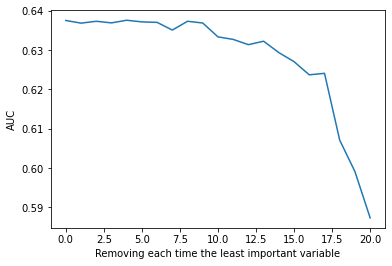

In [72]:
plt.plot([i for i in range(len(auc_per_var))], [i[0] for i in auc_per_var])
plt.xlabel('Removing each time the least important variable')
plt.ylabel('AUC')

# Access best model
best_model_set= max(auc_per_var,key=lambda item:item[0])[2]

print(best_model_set)

In [4]:
d = [ 
    ['chimi', 3],
    ['skjdfhs', 123],
    ['as', 2],
    ['chip', 33]
]

print( max(x[1] for x in d) )
print( max(d,key=lambda item:item[1])[0] )

123
skjdfhs


In [ ]:
# Save the best model

convert_model(model,input_variables=input_vars,output_xml=os.path.join(save_dir,'xgboost-{}.xml'.format(channel)))